# Background

This notebook is based on <br>
**Emily S. C Ching, P. H. Tam, "[Effects of hidden nodes on the reconstruction of bidirectional networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.98.062318)", Phys. Rev. E 98, 062318 (2018)** [1] <br>

The authors in [1] consider a weighted bidirectional network of $N$ nodes, each has state variable $x_{i}(t)$ governed by the coupled stochastic differential equations (SDEs).

\begin{align}
    \frac{dx_{i}}{dt} \; = \; f(x_{i}) \; + \; \sum_{j \neq i}\, g_{ij}A_{ij}h(x_{j} - x_{i}) \; + \; \eta_{i} \tag{1}
\end{align}
for $i = 1, 2, \dots, N$.
* $f(x_{i})$: intrinsic dynamics of node $i$ with a stable fixed point $X_{0}$
* $A_{ij}$: adjacency matrix element
* $g_{ij}$: coupling strength
* $h$: diffusive-like coupling function with $h^{\prime}(0) > 0$ and $h(-z) = -h(z)$
* $\eta_{i}$: Gaussian white noise with $\overline{\eta}_{i} = 0$ and $\overline{\eta_{i}(t) \eta_{j}(t^{\prime})} = \sigma^{2}_{n}\, \delta_{ij} \, \delta(t - t^{\prime})$.

As $t \to \infty$, dynamics of nodes fluctuates around the stable fixed point $X_{0}$ (Stationary Dynamics)

The aim of network reconstruction is to infer the network connectivity $A_{ij}$ from the dynamics of nodes $x_{i}(t)$. This is known as inverse problem. 


# Problem
The authors consider a realistic situation in which some of the nodes are not available for measurements. They asked the following question:

Given only $n < N$ nodes available for measurement, is it possible to infer the network connectivity *among the measured nodes*? [1]

# Mathematical Relation
The authors obtained the following result [1]

\begin{align}
    (\Sigma^{-1}_{m})_{ij} \; = \; - \frac{2h^{\prime}(0)}{\sigma^{2}_{n}} \Big( g_{ij} A_{ij} + C_{ij} \Big) \tag{2}
\end{align}
for $i \neq j$, and $i, j = 1, 2, \dots, n < N$
* $\mathbf{\Sigma^{-1}_{m}}:$ inverse covariance matrix **formed by the measured nodes only**
* $A_{ij}$: adjacency matrix element **among the measured nodes**
* $g_{ij}$: coupling strength **among the measured nodes**
* $C_{ij}$: effect of hidden nodes acting on the measured node $i$ and $j$<br>

**Remarks**
-  Here $i, j$ represents node indices of measured nodes, and they do not necessarily mean the first $n$ node indices of the whole network.
- The authors in [1] consider $h^{\prime}(0) = 1$

This equation shows that even if there are some nodes not available for measurements, $(\Sigma^{-1}_{m})_{ij}$ is still related to $g_{ij}A_{ij}$, the network connectivity among the measured nodes. The details of $C_{ij}$ can be found in [1].

If there are no hidden nodes (i.e. all N nodes can be accessed and their dynamics can be measured), then we have
\begin{align}
    (\Sigma^{-1})_{ij} \; = \; - \frac{2h^{\prime}(0)}{\sigma^{2}_{n}} g_{ij} A_{ij} \tag{3}
\end{align}
for $i \neq j$, and $i, j = 1, 2, \dots, n < N$

**Remarks**
Notice that Eq. (2) also holds for $i \neq j$, and $i, j = 1, 2, \dots, N$.<br>
But as we are going to compare the case with hidden nodes (see below), we constraint ourself to the $n$ measured nodes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import my python packages
import utils
import gen_net
import gen_cov
import choose_nodes
import reconstruct
import evaluate

# Network Generation

First, we choose our network as ER random network with Gaussian coupling.

In [2]:
# Set random seed
np.random.seed(seed=22)

# Construct a weighted random network with Gaussian coupling

# Total number of node
N = 100

# Connection probability
p = 0.2

# Mean value of Gaussian coupling
mean = 10

# Standard deviation of Gaussian coupling
std = 2

# Construct a ER unweighted bidirectional random network
A = gen_net.er_random(N, p)

# Construct the corresponding weighted network with Gaussian coupling strength
W = gen_net.gaussian(A, mean, std)

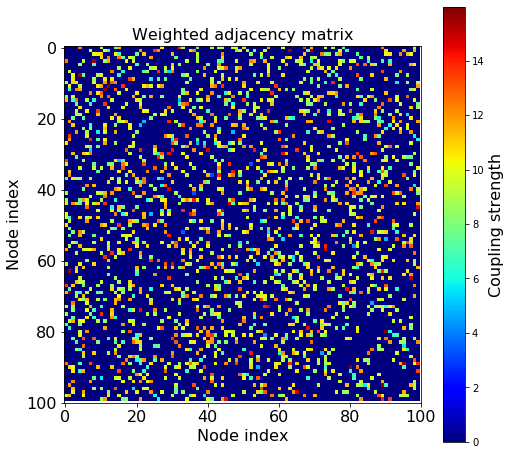

In [3]:
# Image plot the weighted adjacency matrix
fig = plt.figure(figsize=(8, 8))
plt.imshow(W, cmap='jet')
cbar = plt.colorbar()
cbar.set_label("Coupling strength", fontsize=16)
plt.title("Weighted adjacency matrix", fontsize=16)
plt.xlabel("Node index", fontsize=16)
plt.ylabel("Node index", fontsize=16)
plt.xticks(np.arange(0, 120, 20), fontsize=16)
plt.yticks(np.arange(0, 120, 20), fontsize=16)

plt.show()

# Stationarity Checking
To obtain the analytic result in [1], the dynamics has to be stationary. For this class of dynamics to be stationary, we check the eigenvalue of the weighted Laplacian matrix $\mathbf{\mathcal{L}}$

\begin{align}
    \mathcal{L}_{ij} \; = \; \sum_{k} (g_{ik}A_{ik}) \, \delta_{ij} \;\; - \;\; g_{ij}A_{ij} \tag{4}
\end{align}

For Eq. (1) to have stationary dynamics, one of the conditions is that $\mathbf{\mathcal{L}}$ should have no negative eigenvalues.

In [4]:
_ = utils.dynamics.stationary_check(W)

Absolute minimum eigenvalue of L =  1.8234210563328407e-14
The dynamics would probably fluctuate around a stable fixed point


# Dynamics Simulation

In this demo, we choose:
1. $f(x) \; = \; r x(1-x)$
2. $h(x-y) \; = \;  y - x$

Hence, the coupled SDEs becomes

\begin{align}
    \frac{dx_{i}}{dt} \; = \; rx_{i}(1-x_{i}) \; - \; \sum_{j=1}^{N} \mathcal{L}_{ij} \, x_{j} \; + \; \eta_{i} \tag{5}
\end{align}

In the following, we generate the dynamics of $x_{i}(t)$ by solving the coupled SDEs using Euler-Maruyama method and obtain $\mathbf{\Sigma}$, `cov` (the covariance matrix of the whole network)

In [5]:
# Set random seed
np.random.seed(13)


# Parameter for f(x)
r = 10

# Noise strength
sigma = 1

# Integration step
int_dt = 5e-5

# Sampling step
sample_dt = 5e-4

# Time step to begin sampling
sample_start = int(5e3)

# Total number of data points to compute covariance matrix
data_num = int(2e6)

# cov: covariance matrix formed by ALL the nodes
# x_ts: sampled time series of the first node
cov, x_ts = gen_cov.logistic_diffusive(W, r, sigma, int_dt, sample_dt, sample_start, data_num, get_ts=True)

100%|██████████| 20005000/20005000 [11:38<00:00, 28621.02it/s]


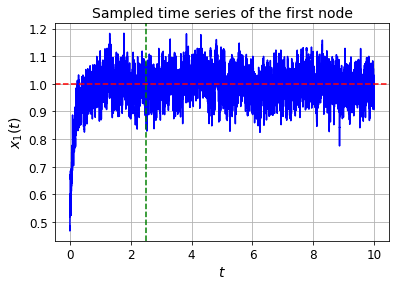

In [6]:
# Plot part of the sampled time series of the first node
t = np.arange(len(x_ts))*sample_dt

# We plot only part of the time series for better visualization
plt.plot(t[:20000], x_ts[:20000], color='b')

# Green line is the time step we start do the sampling for covariance computation
# It is used to avoid the transient dynamics at the very beginning
plt.axvline(x=sample_start*sample_dt, color='g', linestyle='--')

# Red line is the stable fixed point of f(x)
# We see the dynamics is fluctuating around it
plt.axhline(y=1, color='r', linestyle='--')

plt.title("Sampled time series of the first node", fontsize=14)
plt.xlabel(r"$t$", fontsize=14)
plt.ylabel(r"$x_{1}(t)$", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Node Selection

In the following, we choose $n = 30$ nodes from $N=100$ nodes as measured nodes randomly.<br>

With the selected node indices `measure_id` and `hidden_id`, we can compute
1. `cov_m_inv` Eq.(2)
2. `cov_inv_m` Eq. (3)

from `cov` generated from the above simulation. <br>

In [7]:
# Set random seed
np.random.seed(19)

# Number of measured nodes
n = 30

# Get the node indices that corresponds to measured nodes and hidden nodes
measure_id, hidden_id = choose_nodes.random(N, n)

# cov_inv_m and cov_m_inv is computed from cov
cov_inv_m, cov_m_inv = utils.dynamics.inverse_covariance(cov, measure_id, hidden_id)

# Data Visualization
We extract the off-diagonal elements of `cov_m_inv` and `cov_inv_m` and they should be distributed according to Eq. (2), and (3) respectively. We also label the data point according to $A_{ij} = 0$ or $1$.

In [8]:
# Get the network connectivity among the measured nodes
W_m = utils.base.block_diag_up(W, measure_id)
W_m_off = utils.base.off_diag_upper(W_m)

In [9]:
# Select only the off-diagonal elements (upper triangle)
data_nohidden = utils.base.off_diag_upper(cov_inv_m)
data_hidden = utils.base.off_diag_upper(cov_m_inv)

# Separate the data into unconnected and connected as if we know the underlying connectivity
ucon_nohidden = data_nohidden[W_m_off == 0]
conn_nohidden = data_nohidden[W_m_off != 0]

ucon_hidden = data_hidden[W_m_off == 0]
conn_hidden = data_hidden[W_m_off != 0]

In [106]:
# Get the number of count in the histogram
num_bin = 50
bin_lims = np.linspace(-45, 5, num_bin+1)
bin_centre = 0.5*(bin_lims[:-1]+bin_lims[1:])

ucon_nohidden_count, _ = np.histogram(ucon_nohidden, bins=bin_lims)
conn_nohidden_count, _ = np.histogram(conn_nohidden, bins=bin_lims)

ucon_hidden_count, _ = np.histogram(ucon_hidden, bins=bin_lims)
conn_hidden_count, _ = np.histogram(conn_hidden, bins=bin_lims)

In [107]:
# Remove zero count elements
ucon_nohidden_bin_centre = bin_centre[ucon_nohidden_count != 0]
conn_nohidden_bin_centre = bin_centre[conn_nohidden_count != 0]
ucon_nohidden_count = ucon_nohidden_count[ucon_nohidden_count != 0]
conn_nohidden_count = conn_nohidden_count[conn_nohidden_count != 0]

ucon_hidden_bin_centre = bin_centre[ucon_hidden_count != 0]
conn_hidden_bin_centre = bin_centre[conn_hidden_count != 0]
ucon_hidden_count = ucon_hidden_count[ucon_hidden_count != 0]
conn_hidden_count = conn_hidden_count[conn_hidden_count != 0]


# Normalize the histogram AS A WHOLE
nohidden_total_count =  np.sum(ucon_nohidden_count) + np.sum(conn_nohidden_count)
ucon_nohidden_dens = ucon_nohidden_count / nohidden_total_count
conn_nohidden_dens = conn_nohidden_count / nohidden_total_count

hidden_total_count =  np.sum(ucon_hidden_count) + np.sum(conn_hidden_count)
ucon_hidden_dens = ucon_hidden_count / hidden_total_count
conn_hidden_dens = conn_hidden_count / hidden_total_count

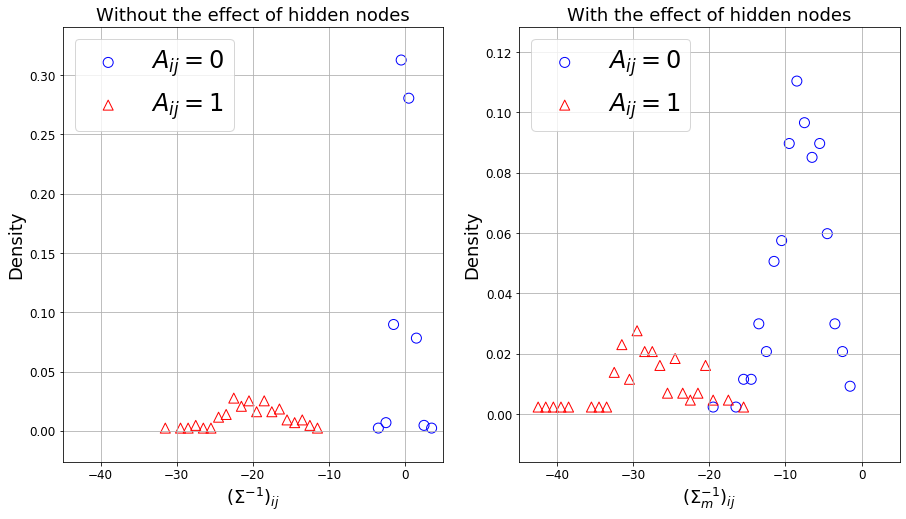

In [143]:
# Plot the distribution
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.scatter(ucon_nohidden_bin_centre, ucon_nohidden_dens, s=100, color='blue', marker='o', facecolor='None')
plt.scatter(conn_nohidden_bin_centre, conn_nohidden_dens, s=100, color='red', marker='^', facecolor='None')
plt.legend([r'$A_{ij} = 0$', r'$A_{ij} = 1$'], fontsize=24)
plt.xlim(-45, 5)
plt.xlabel(r'$(\Sigma^{-1})_{ij}$', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Without the effect of hidden nodes', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)


plt.subplot(1, 2, 2)
plt.scatter(ucon_hidden_bin_centre, ucon_hidden_dens, s=100, color='blue', marker='o', facecolor='None')
plt.scatter(conn_hidden_bin_centre, conn_hidden_dens, s=100, color='red', marker='^', facecolor='None')
plt.legend([r'$A_{ij} = 0$', r'$A_{ij} = 1$'], fontsize=24)
plt.xlim(-45, 5)
plt.xlabel(r'$(\Sigma_{m}^{-1})_{ij}$', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('With the effect of hidden nodes', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

1. **Left**: A bimodal distribution is observed with unconnected data points around zero as Eq. (2) suggested. The data points for $A_{ij} = 0$ and $1$ are well separated.

2. **Right**: A bimodal distribution is still observed even if there are 70 out of 100 nodes are hidden nodes. What is remarkable is that when you compare with the **Left** figure, the whole distribution is shifted to the left by roughly the same amount without distorting the bimodal feature.

Why is it the case? Let's take a look at $C_{ij}$ for $i \neq j$, the effect of hidden node

# The Hidden Node Effect
Let's look at the behaviour of $C_{ij}$ and see how it actually affect the distribution

In [11]:
C = utils.network.hidden_effect(W, measure_id, hidden_id, a=r)

In [12]:
# Select only the off-diagonal elements (upper triangle)
C_off = utils.base.off_diag_upper(C)
C_ucon = C_off[W_m_off == 0]
C_conn = C_off[W_m_off != 0]

In [135]:
# Get the number of count in the histogram
num_bin = 12
bin_lims = np.linspace(0, 10, num_bin+1)
bin_centre = 0.5*(bin_lims[:-1]+bin_lims[1:])
C_ucon_count, _ = np.histogram(C_ucon, bins=bin_lims)
C_conn_count, _ = np.histogram(C_conn, bins=bin_lims)

# Remove zero count elements
C_ucon_bin_centre = bin_centre[C_ucon_count != 0]
C_conn_bin_centre = bin_centre[C_conn_count != 0]
C_ucon_count = C_ucon_count[C_ucon_count != 0]
C_conn_count = C_conn_count[C_conn_count != 0]

# Normalize the histogram SEPARATELY
C_ucon_dens = C_ucon_count / np.sum(C_ucon_count)
C_conn_dens = C_conn_count / np.sum(C_conn_count)

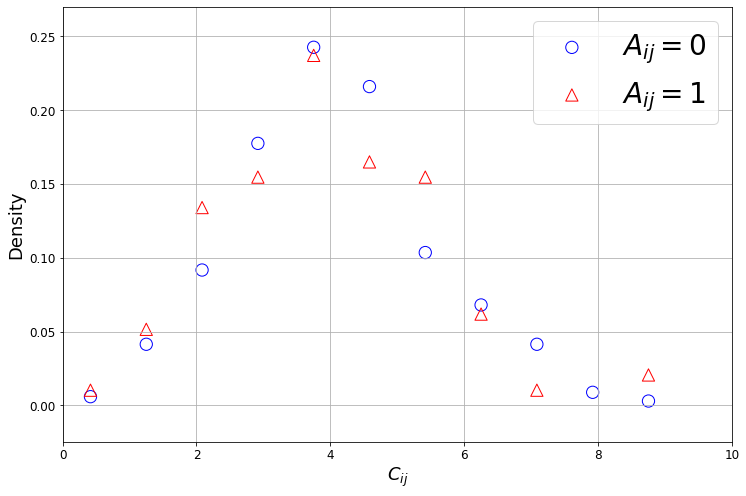

In [144]:
# Plot the distribution
plt.figure(figsize=(12, 8))
plt.scatter(C_ucon_bin_centre, C_ucon_dens, s=150, color='blue', marker='o', facecolor='None')
plt.scatter(C_conn_bin_centre, C_conn_dens, s=150, color='red', marker='^', facecolor='None')
plt.legend([r'$A_{ij} = 0$', r'$A_{ij} = 1$'], fontsize=28)
plt.xlim(0, 10)
plt.xlabel(r'$C_{ij}$', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

The distribution shows that $C_{ij}$ takes similar value no matter the measured node pair $(i, j)$ is connected or unconnected. 

In other words, $C_{ij}$ in this case (ER Random Network) is **independent** on $A_{ij}$. 

Therefore, the whole distribution of $(\Sigma^{-1}_{m})_{ij}$ is basically shifted to the left **without** distorting the bimodal behaviour.

# Network Reconstruction
Using **k-means clustering** to reconstruct the underlying network connectivity.<br>

Clustered data with centroid close to zero are reconstructed as unconnected pairs. Otherwise, they are reconstructed as connected pairs.

In [14]:
# k-means cluster the data and reconstruct the adjacency matrix
A_reco_nohidden = reconstruct.kmeans(data_nohidden, n, k=2)
A_reco_hidden = reconstruct.kmeans(data_hidden, n, k=2)

# Reconstructed Results

Let's compare the reconstructed adjacency matrix with the actual adjacency matrix among the measured nodes

In [15]:
# Get the original adjacency matrix among the measured nodes
A_m = W_m
A_m = (A_m != 0).astype('int')

In [16]:
# Error rates for data with no hidden node effect
_, _, _ = evaluate.error_rates(A_m, A_reco_nohidden)

Number of bidirectional links = 97
Number of false positive = 0
Number of false negative = 0
False positive rate = 0.0000%
False negative rate = 0.0000%


In [17]:
# Error rates for data with hidden node effect
_, _, _, = evaluate.error_rates(A_m, A_reco_hidden)

Number of bidirectional links = 97
Number of false positive = 1
Number of false negative = 3
False positive rate = 1.0309%
False negative rate = 3.0928%


# Conclusion 
1. The one without hidden node effect has a perfect network reconstruction. 
2. Even the one with hidden node effect (70 out of 100 are hidden nodes), the result is also acceptable